In [1]:
# Import project dependencies
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
import tensorflow as tf

In [2]:
# Import the diabetes readmission data
url = "https://raw.githubusercontent.com/eadigun24/Diabetes_Admission_Analysis/adigun/Resources/diabetic_data.csv"
readmission_df = pd.read_csv(url)

In [3]:
# display the top five rows of the dataframe
readmission_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [4]:
# Create a copy of the original dataframe to preserve any pre - preprocessing changes.
readmission_pre_cleansed_df = readmission_df.copy()
readmission_pre_cleansed_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [5]:
# drop columns not vital to the model.
colums_to_drop = ['encounter_id', 'patient_nbr', 'weight'
                 , 'payer_code', 'medical_specialty'
                 , 'max_glu_serum', 'A1Cresult'
                 , 'diag_1', 'diag_2', 'diag_3'
                 , 'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide'
                 , 'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide'
                 , 'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone'
                 , 'tolazamide', 'examide', 'citoglipton', 'insulin'
                 , 'glyburide-metformin', 'glipizide-metformin'
                 , 'glimepiride-pioglitazone', 'metformin-rosiglitazone'
                 , 'metformin-pioglitazone']
readmission_pre_cleansed_df = readmission_pre_cleansed_df.drop(columns=colums_to_drop)

In [6]:
# Create ordinal encoders to encode specific columns
diabetesMed_ode = OrdinalEncoder(categories=[['Yes','No']], encoded_missing_value=-1, handle_unknown='use_encoded_value', unknown_value=-1)
diabetesMed_ode.fit(readmission_pre_cleansed_df['diabetesMed'].values.reshape(-1,1))

change_ode = OrdinalEncoder(categories=[['No','Ch']], encoded_missing_value=-1, handle_unknown='use_encoded_value', unknown_value=-1)
change_ode.fit(readmission_pre_cleansed_df['change'].values.reshape(-1,1))

OrdinalEncoder(categories=[['No', 'Ch']], encoded_missing_value=-1,
               handle_unknown='use_encoded_value', unknown_value=-1)

In [7]:
# Create one hot encoders to encode the columns specified below.
race_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
race_ohe.fit(readmission_pre_cleansed_df['race'].values.reshape(-1,1))

gender_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
gender_ohe.fit(readmission_pre_cleansed_df['gender'].values.reshape(-1,1))

age_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
age_ohe.fit(readmission_pre_cleansed_df['age'].values.reshape(-1,1))

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [8]:
def X_preprocess(X_data):
    # Transform each colum into numpy arrays
    diabetesMed_encoded = diabetesMed_ode.transform(X_data['diabetesMed'].values.reshape(-1,1))
    change_encoded = change_ode.transform(X_data['change'].values.reshape(-1,1))
    race_encoded = race_ohe.transform(X_data['race'].values.reshape(-1,1))
    gender_encoded = gender_ohe.transform(X_data['gender'].values.reshape(-1,1))
    age_encoded = age_ohe.transform(X_data['age'].values.reshape(-1,1))

    # Reorganize the numpy arrays into a DataFrame
    race_df = pd.DataFrame(race_encoded, columns= race_ohe.get_feature_names_out())
    gender_df = pd.DataFrame(gender_encoded, columns= gender_ohe.get_feature_names_out())
    age_df = pd.DataFrame(age_encoded, columns= age_ohe.get_feature_names_out())
    out_df =pd.concat([race_df, gender_df, age_df], axis=1)
    out_df['change'] = change_encoded
    out_df['diabetesMed'] = diabetesMed_encoded

    # Return the DataFrame
    return out_df

In [9]:
# Create the encoded dataframe ...
readmission_post_cleansed_df = X_preprocess(readmission_pre_cleansed_df)
readmission_post_cleansed_df.head()


,x0_AfricanAmerican,x0_Asian,x0_Caucasian,x0_Hispanic,x0_Other,x0_Male,x0_Unknown/Invalid,x0_[10-20),x0_[20-30),x0_[30-40),x0_[40-50),x0_[50-60),x0_[60-70),x0_[70-80),x0_[80-90),x0_[90-100),change,diabetesMed
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [10]:
readmission_post_cleansed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   x0_AfricanAmerican  101766 non-null  float64
 1   x0_Asian            101766 non-null  float64
 2   x0_Caucasian        101766 non-null  float64
 3   x0_Hispanic         101766 non-null  float64
 4   x0_Other            101766 non-null  float64
 5   x0_Male             101766 non-null  float64
 6   x0_Unknown/Invalid  101766 non-null  float64
 7   x0_[10-20)          101766 non-null  float64
 8   x0_[20-30)          101766 non-null  float64
 9   x0_[30-40)          101766 non-null  float64
 10  x0_[40-50)          101766 non-null  float64
 11  x0_[50-60)          101766 non-null  float64
 12  x0_[60-70)          101766 non-null  float64
 13  x0_[70-80)          101766 non-null  float64
 14  x0_[80-90)          101766 non-null  float64
 15  x0_[90-100)         101766 non-nul

In [11]:
sub_readmission_df = readmission_pre_cleansed_df.drop(columns=['race','gender','age','change','diabetesMed'])

In [12]:
combined_readmission_df = pd.concat([sub_readmission_df, readmission_post_cleansed_df], axis=1)
combined_readmission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   admission_type_id         101766 non-null  int64  
 1   discharge_disposition_id  101766 non-null  int64  
 2   admission_source_id       101766 non-null  int64  
 3   time_in_hospital          101766 non-null  int64  
 4   num_lab_procedures        101766 non-null  int64  
 5   num_procedures            101766 non-null  int64  
 6   num_medications           101766 non-null  int64  
 7   number_outpatient         101766 non-null  int64  
 8   number_emergency          101766 non-null  int64  
 9   number_inpatient          101766 non-null  int64  
 10  number_diagnoses          101766 non-null  int64  
 11  readmitted                101766 non-null  object 
 12  x0_AfricanAmerican        101766 non-null  float64
 13  x0_Asian                  101766 non-null  f

In [13]:
combined_readmission_df['readmitted'] = combined_readmission_df['readmitted'].replace({"NO": 0, "<30": 1, ">30": 2})
combined_readmission_df['readmitted'] = pd.to_numeric(combined_readmission_df['readmitted'])
combined_readmission_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 30 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   admission_type_id         101766 non-null  int64  
 1   discharge_disposition_id  101766 non-null  int64  
 2   admission_source_id       101766 non-null  int64  
 3   time_in_hospital          101766 non-null  int64  
 4   num_lab_procedures        101766 non-null  int64  
 5   num_procedures            101766 non-null  int64  
 6   num_medications           101766 non-null  int64  
 7   number_outpatient         101766 non-null  int64  
 8   number_emergency          101766 non-null  int64  
 9   number_inpatient          101766 non-null  int64  
 10  number_diagnoses          101766 non-null  int64  
 11  readmitted                101766 non-null  int64  
 12  x0_AfricanAmerican        101766 non-null  float64
 13  x0_Asian                  101766 non-null  f

In [14]:
columns_to_drop = ['x0_AfricanAmerican', 'x0_Asian', 'x0_Caucasian', 'x0_Hispanic',
       'x0_Other', 'x0_Male', 'x0_Unknown/Invalid', 'x0_[10-20)', 'x0_[20-30)',
       'x0_[30-40)', 'x0_[40-50)', 'x0_[50-60)', 'x0_[60-70)', 'x0_[70-80)',
       'x0_[80-90)', 'x0_[90-100)']
combined_readmission_df = combined_readmission_df.drop(columns=columns_to_drop)

In [15]:
# Get the features data from the DataFrame.
X = combined_readmission_df.drop(columns='readmitted')

# Get the target series from the DataFrame.
y  = combined_readmission_df['readmitted']

# Split the data into training and testing dataframes.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [16]:
# Scale the data ...
# Instantiate the StandardScaler instance
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_trained_scaled  = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [17]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

In [18]:
# Set input nodes to the number of features
input_nodes = len(X.columns)
hidden_nodes_layer1 = 26
hidden_nodes_layer2 = 13

# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, activation="leaky_relu", input_dim=input_nodes))

# Add second hidden layer
nn_model.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="leaky_relu"))

# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 26)                  │             364 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 13)                  │             351 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              14 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 729 (2.85 KB)

 Trainable params: 729 (2.85 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model = nn_model.fit(X_trained_scaled, y_train, epochs=100)

Epoch 1/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.2085 - loss: -4.2513
Epoch 2/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2607 - loss: -186.2884
Epoch 3/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2632 - loss: -869.2355
Epoch 4/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2613 - loss: -2282.9690
Epoch 5/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2617 - loss: -4844.4277
Epoch 6/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2662 - loss: -8436.5605
Epoch 7/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.2584 - loss: -12794.7090
Epoch 8/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2612 - loss: -18590.7207
Epoch 9/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.2590 - loss: -26400.3652
Epoch 10/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.2599 - loss: -34609.1094
Epoch 11/100
2386/2386 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0

<Axes: >

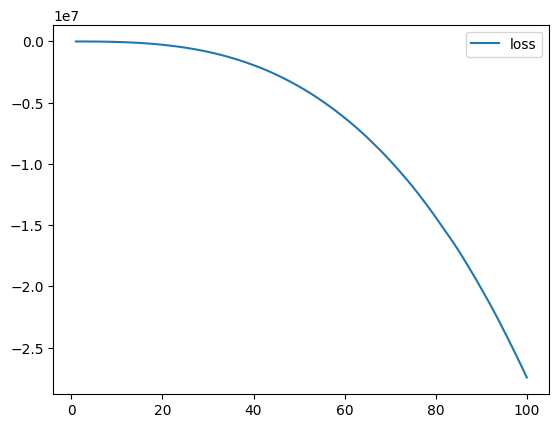

In [21]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

<Axes: >

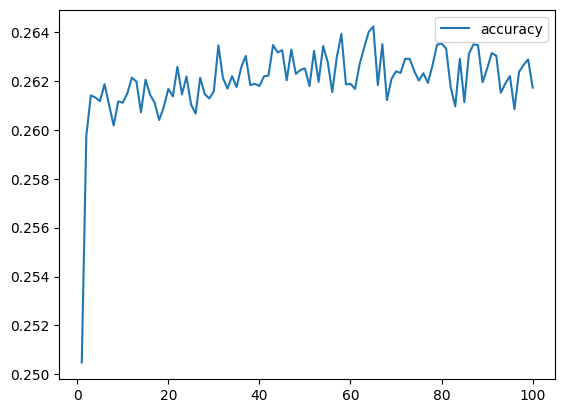

In [22]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [23]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test, y_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

796/796 - 1s - 1ms/step - accuracy: 0.1086 - loss: 174270368.0000
Loss: 174270368.0, Accuracy: 0.10856064409017563


In [24]:
# Make predictions
predictions = nn_model.predict(X_test,verbose=2)
predictions

796/796 - 1s - 1ms/step


array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [25]:
# Compare with random forest model
from sklearn.ensemble import RandomForestClassifier

# Create the random forest classifier model
# with n_estimators=128 and random_state=1
rf_model = RandomForestClassifier(n_estimators=128, random_state=1)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Validate the model by checking the model accuracy with model.score
print(f"Training Data Score: {rf_model.score(X_train, y_train)}")
print(f"Testing Data Score: {rf_model.score(X_test, y_test)}")

Training Data Score: 0.9961480006288979
Testing Data Score: 0.5574247307601604
